In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from models.concept import ConceptModel

## Learning Concepts

In this notebook, we experiment with how to learn the function $f(c|...)$ which models a set of inputs to the ouput concept. The dataset used here is generated in the windy gridworld environment. The following conditional relationships will be explored:

* $f(c|s)$
* $f(c|s,a)$
* $f(c|s,a,s')$
* $f(c|s,a,r_{s}$ where $r_s$ is the short term reward
* $f(c|s,a,r_{l})$ where $r_l$ is the longer term reward
* $f(c|s,a,\bar{s})$ where $\bar{s}$ may indicate the k-NN of state s for example
* $f(c|s,a,\theta)$ where $\theta$ is some unknown parameter

A MLP will be used to model these functions in order to learn a mapping from the set of inputs to the concept.


In [2]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_more_concepts.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(1090,)
(1090,)
(1090,)
(1090,)
(1090,)
(10, 2)
(500, 2)


## Preprocessing

Apply any preprocessing at this point.

In [4]:
num_concepts = len(means)
up = np.array([0, 1])
down = np.array([0, -1])
right = np.array([1, 0])
left = np.array([-1, 0])

A = np.array([up, down, right, left])


def generate_default_dataset(window_size):
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_actions_dataset(window_size=5):
    '''Adds third element to input vector which is the action taken in the current state'''
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    X = np.concatenate((X, actions_indexed), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_voted_actions_dataset():
    '''Adds third element to input vector which is the action taken in the current state'''
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories))
    actions_voted = np.concatenate(generate_voted_actions(w_size=5))
    actions_voted = actions_voted.reshape(len(actions_voted), 1)
    X = np.concatenate((X, actions_voted), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_states_dataset():
    '''s,s' '''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)

    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_states_actions_dataset():
    '''s,s',a'''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted, actions_indexed), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_next_n_states_dataset(window=6, smoothing_window=5):
    '''s, s'+n'''
    windowed_states = window_states(trajectories, W_s=smoothing_window)
    shifted_trajectories = shifted_state_vector(
        windowed_states, mode="future", w_size=window)
    X = np.concatenate(shifted_trajectories)
    Y = np.concatenate(concepts)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)

def generate_windowed_rewards(smoothing_window=5, lookback=20, distance=0.15):
    '''Counts the reward accumlated in moving a fixed distance in the positive x and positive y directions'''
    windowed_states = window_states(trajectories, W_s=smoothing_window)
    windowed_rewards = []
    for k, traj in enumerate(windowed_states):
        rewards = np.zeros(len(traj))
        for i, state in enumerate(traj):
            for j in range(1,lookback+1): 
                v = state - traj[(i-j) if i > j else j]
                hyp = np.sqrt(v[0]**2+v[1]**2) #hypotenuse
                theta = np.arcsin(v[1]/hyp) * 180.0/np.pi #degrees
                if hyp >= distance and theta >= 10.0 and theta <= 80.0:
                    rewards[i] = j
                    break
                if j == lookback:
                    rewards[i] = j
        windowed_rewards.append(rewards)

    X = np.concatenate(windowed_rewards)
    Y = np.concatenate(concepts)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)
                    


def window_states(trajectories, W_s=5):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


def generate_voted_actions(w_size=10):
    '''Removes some noise from the action policy by setting the action taken to a vote over the previous W_a actions'''
    voted_actions = []
    for traj in actions:
        voted_traj = np.zeros((len(traj)))
        indicies = actions_to_action_indexes(traj)
        for i in range(1, len(traj)+1):
            window = indicies[i - min(w_size, i):i]
            action_vote, _ = Counter(window).most_common(1)[0]
            voted_traj[i-1] = action_vote
        voted_actions.append(voted_traj)
    return np.array(voted_actions, dtype='object')


def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)


def shift_states(trajectories):
    shifted_trajectories = []
    for traj in trajectories:
        n = len(traj)-1
        shifted = np.zeros(traj.shape)
        shifted[0:n-1] = traj[1:n]
        shifted[n] = shifted[n-1]
        shifted_trajectories.append(shifted)
    return shifted_trajectories


def shifted_state_vector(trajectories, mode="future", w_size=6):
    '''Each state vector used as input to a model is augmented with the future/previous/surrounding n states. i.e. input vector goes from (1,2)->(1,2*w)'''

    shifted_trajectories = []
    for traj in trajectories:
        n = len(traj)-1
        shifted = np.zeros((traj.shape[0], traj.shape[1]*w_size))
        for i in range(len(shifted)):
            if mode == "future":
                if i <= (n-w_size)+1:
                    shifted[i] = np.concatenate(traj[i:i+w_size])
                else:
                    j = w_size-(n-i)-1
                    shifted[i] = np.concatenate(
                        np.vstack((traj[i:i+w_size], np.tile(traj[-1], j).reshape(j, 2))))

        shifted_trajectories.append(shifted)
    return shifted_trajectories

## $f(c|s)$

In [5]:
X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
model1 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history1 = model1.fit(X_train, y_train, epochs=7, batch_size=32, validation_split=0.2, verbose = 1)
model1.save("saved_models/c_10|s")

(338723, 2)
(338723, 10)
Epoch 1/7
8469/8469 [==============================] - 17s 2ms/step - loss: 0.2319 - categorical_accuracy: 0.9020 - val_loss: 0.1708 - val_categorical_accuracy: 0.9243
Epoch 2/7
8469/8469 [==============================] - 14s 2ms/step - loss: 0.1652 - categorical_accuracy: 0.9279 - val_loss: 0.1550 - val_categorical_accuracy: 0.9355
Epoch 3/7
8469/8469 [==============================] - 14s 2ms/step - loss: 0.1552 - categorical_accuracy: 0.9329 - val_loss: 0.1534 - val_categorical_accuracy: 0.9343
Epoch 4/7
8469/8469 [==============================] - 11s 1ms/step - loss: 0.1495 - categorical_accuracy: 0.9353 - val_loss: 0.1656 - val_categorical_accuracy: 0.9310
Epoch 5/7
8469/8469 [==============================] - 10s 1ms/step - loss: 0.1462 - categorical_accuracy: 0.9365 - val_loss: 0.1407 - val_categorical_accuracy: 0.9390
Epoch 6/7
8469/8469 [==============================] - 10s 1ms/step - loss: 0.1441 - categorical_accuracy: 0.9374 - val_loss: 0.1405 - 

In [ ]:
model_scores = []
for W in [1, 5, 10, 15]:
    scores = np.zeros((3))
    X_train, X_test, y_train, y_test = generate_default_dataset(window_size=W)
    print(X_train.shape)
    print(y_train.shape)
    model1 = ConceptModel(
        input_size=X_train[0].shape, num_concepts=num_concepts).build()
    history1 = model1.fit(X_train, y_train, epochs=2,
                          batch_size=32, validation_split=0.2, verbose=1)
    score = model1.evaluate(X_test, y_test)
    scores[0] = history1.history["categorical_accuracy"][-1]
    scores[1] = history1.history["val_categorical_accuracy"][-1]
    scores[2] = score[1]
    model_scores.append(scores)


Text(0.5, 1.0, 'Model accuracy for different look ahead window sizes (kNN)')

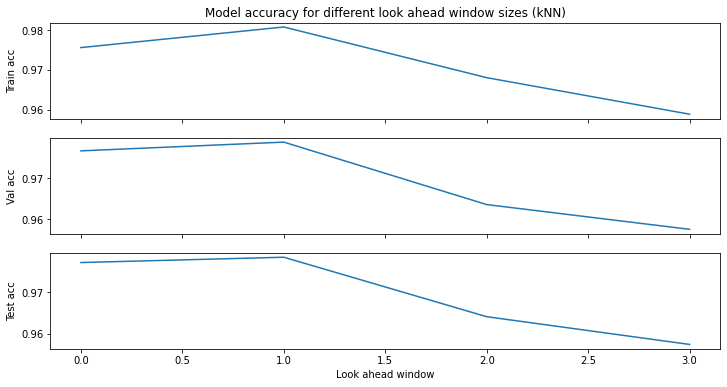

In [654]:
model_scores = np.array(model_scores)
num_cols = model_scores.shape[1]

# Plot each column in a separate subplot
fig, axs = plt.subplots(nrows=num_cols, sharex=True,)
labels = ["Train acc","Val acc","Test acc"]

for i in range(num_cols):
    axs[i].plot(model_scores[:,i])
    axs[i].set_ylabel(labels[i])
axs[-1].set_xlabel("Look ahead window")
fig.set_figheight(6)
fig.set_figwidth(12)
axs[0].set_title("Model accuracy for different look ahead window sizes (kNN)")

In [152]:
X_window = window_states(trajectories, W_s=5)

Number of misclassified concepts: 6
Reward: -504


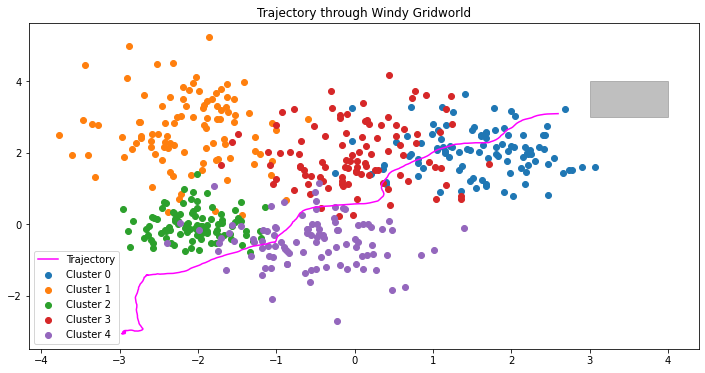

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 4 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [71]:
fig, ax2 = plt.subplots(figsize=(12,6))

index = np.random.randint(0,len(X_window))
index=0
history = np.array(X_window[index])
concept_history = concepts[index]
predicted_concepts = np.argmax(model1.predict(history), axis=1)

errors = len(np.where((concept_history - predicted_concepts)>0)[0])
print(f"Number of misclassified concepts: {errors}")


# print(f"Concepts visited: {concepts[index]}")
print(f"Reward: {rewards[index]}")
plt.plot(history[:, 0], history[:, 1], color="magenta", label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()


print(concept_history)
print(predicted_concepts)

## $f(c|s,a)$

In [10]:
X_train, X_test, y_train, y_test = generate_states_actions_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
model2 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
model2.save("saved_models/c|s-a")

(322004, 3)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0649 - categorical_accuracy: 0.9741 - val_loss: 0.0389 - val_categorical_accuracy: 0.9831
Epoch 2/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0448 - categorical_accuracy: 0.9803 - val_loss: 0.0529 - val_categorical_accuracy: 0.9766
Epoch 3/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0432 - categorical_accuracy: 0.9813 - val_loss: 0.0441 - val_categorical_accuracy: 0.9803
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0418 - categorical_accuracy: 0.9817 - val_loss: 0.0447 - val_categorical_accuracy: 0.9798
Epoch 5/10
8051/8051 [==============================] - 8s 1ms/step - loss: 0.0412 - categorical_accuracy: 0.9819 - val_loss: 0.0477 - val_categorical_accuracy: 0.9791
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0408 - categorical_accuracy: 0.9819 - val_loss: 0.0386 

## $f(c|s,\bar{a})$

In [11]:
X_train, X_test, y_train, y_test = generate_states_voted_actions_dataset() # generate_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model3 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history2 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
model3.save("saved_models/c|s-a_voted")

(322004, 3)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0652 - categorical_accuracy: 0.9743 - val_loss: 0.0407 - val_categorical_accuracy: 0.9820
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0435 - categorical_accuracy: 0.9812 - val_loss: 0.0389 - val_categorical_accuracy: 0.9829
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0413 - categorical_accuracy: 0.9821 - val_loss: 0.0459 - val_categorical_accuracy: 0.9800
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0404 - categorical_accuracy: 0.9824 - val_loss: 0.0362 - val_categorical_accuracy: 0.9839
Epoch 5/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0398 - categorical_accuracy: 0.9825 - val_loss: 0.0381 - val_categorical_accuracy: 0.9830
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0394 - categorical_accuracy: 0.9828 - val_loss: 0.0375 - v

## $f(c|s,s')$

In [12]:
X_train, X_test, y_train, y_test = generate_states_next_states_dataset()
print(X_train.shape)
print(y_train.shape)
model4 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history3 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
model4.save("saved_models/c|s-s_dash")

(322004, 4)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0591 - categorical_accuracy: 0.9765 - val_loss: 0.0506 - val_categorical_accuracy: 0.9780
Epoch 2/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0398 - categorical_accuracy: 0.9829 - val_loss: 0.0354 - val_categorical_accuracy: 0.9847
Epoch 3/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0381 - categorical_accuracy: 0.9832 - val_loss: 0.0327 - val_categorical_accuracy: 0.9858
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0378 - categorical_accuracy: 0.9836 - val_loss: 0.0349 - val_categorical_accuracy: 0.9848
Epoch 5/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0366 - categorical_accuracy: 0.9840 - val_loss: 0.0354 - val_categorical_accuracy: 0.9850
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0361 - categorical_accuracy: 0.9845 - val_loss: 0.0350

In [11]:
score = model3.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 633us/step - loss: 0.0325 - categorical_accuracy: 0.9858
Test loss: 0.03245977312326431 
Test accuracy: 0.9858262538909912


## $f(c|s,a,s')$

In [13]:
X_train, X_test, y_train, y_test = generate_states_next_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model5 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history4 = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
model5.save("saved_models/c|s-a-s_dash")

(322004, 5)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0604 - categorical_accuracy: 0.9758 - val_loss: 0.0415 - val_categorical_accuracy: 0.9824
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0389 - categorical_accuracy: 0.9829 - val_loss: 0.0325 - val_categorical_accuracy: 0.9857
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.0366 - categorical_accuracy: 0.9841 - val_loss: 0.0312 - val_categorical_accuracy: 0.9864
Epoch 4/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0353 - categorical_accuracy: 0.9845 - val_loss: 0.0352 - val_categorical_accuracy: 0.9841
Epoch 5/10
8051/8051 [==============================] - 13s 2ms/step - loss: 0.0337 - categorical_accuracy: 0.9852 - val_loss: 0.0301 - val_categorical_accuracy: 0.9864
Epoch 6/10
8051/8051 [==============================] - 12s 1ms/step - loss: 0.0325 - categorical_accuracy: 0.9858 - val_loss: 0.040

In [13]:
score = model4.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 734us/step - loss: 0.0274 - categorical_accuracy: 0.9877
Test loss: 0.02739015407860279 
Test accuracy: 0.9876647591590881


## $f(c|s_w')$

* In this experiment, we are trying to learn a function mapping a window of $w$ future/previous/centered states to concepts.
* It is evident from previous experiments that there is little information pertaining to the concepts in the action history.

In [14]:
X_train, X_test, y_train, y_test = generate_states_next_n_states_dataset(window=10, smoothing_window=5)
print(X_train.shape)
print(y_train.shape)
model6 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history5 = model6.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
model6.save("saved_models/c|s_dash_window")

(322004, 20)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0716 - categorical_accuracy: 0.9704 - val_loss: 0.1130 - val_categorical_accuracy: 0.9568
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0468 - categorical_accuracy: 0.9798 - val_loss: 0.0385 - val_categorical_accuracy: 0.9843
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.0428 - categorical_accuracy: 0.9814 - val_loss: 0.0444 - val_categorical_accuracy: 0.9804
Epoch 4/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.0410 - categorical_accuracy: 0.9822 - val_loss: 0.0464 - val_categorical_accuracy: 0.9810
Epoch 5/10
8051/8051 [==============================] - 14s 2ms/step - loss: 0.0401 - categorical_accuracy: 0.9826 - val_loss: 0.0405 - val_categorical_accuracy: 0.9816
Epoch 6/10
8051/8051 [==============================] - 16s 2ms/step - loss: 0.0387 - categorical_accuracy: 0.9830 - val_loss: 0.0332

In [15]:
#Test accuracy
history5.history["val_categorical_accuracy"][-1]
score = model5.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 714us/step - loss: 0.0370 - categorical_accuracy: 0.9837
Test loss: 0.03701065108180046 
Test accuracy: 0.9836896657943726


In [ ]:
#Look ahead window size versus accuracy experiment
model_scores = []
for w_size in [1,5,10,15,20,25,30]:
    scores = np.zeros((3))
    X_train, X_test, y_train, y_test = generate_states_next_n_states_dataset(window=w_size, smoothing_window=5)
    print(X_train.shape)
    print(y_train.shape)
    model5 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
    history5 = model5.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
    score = model5.evaluate(X_test, y_test)
    scores[0] = history5.history["categorical_accuracy"][-1]
    scores[1] = history5.history["val_categorical_accuracy"][-1]
    scores[2] = score[1]
    model_scores.append(scores)

model_scores
    


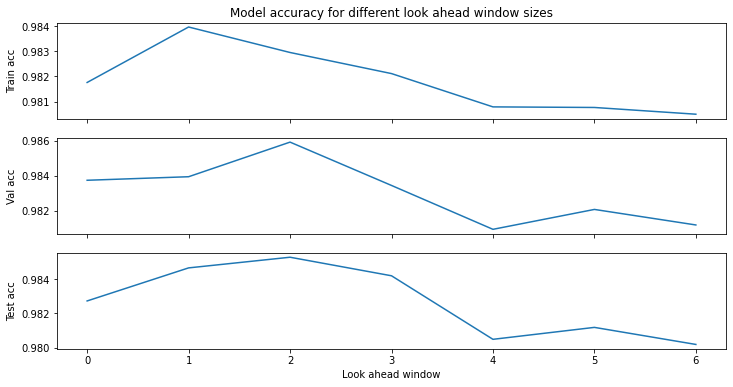

In [8]:
# Get the number of columns in the matrix
model_scores = np.array(model_scores)
num_cols = model_scores.shape[1]

# Plot each column in a separate subplot
fig, axs = plt.subplots(nrows=num_cols, sharex=True,)
labels = ["Train acc","Val acc","Test acc"]

for i in range(num_cols):
    axs[i].plot(model_scores[:,i])
    axs[i].set_ylabel(labels[i])
axs[-1].set_xlabel("Look ahead window")
fig.set_figheight(6)
fig.set_figwidth(12)
axs[0].set_title("Model accuracy for different look ahead window sizes")
    
plt.show()

## $f(c|r')$
Here $r'$ is defined as the reward accumulated in moving a fixed distance in the positive x and positive y direction with any angle.

In [153]:
p = [-0.5, -0.5]
p = X_window[0][47] - X_window[0][47-16]
print(p)
hyp = np.sqrt(p[0]**2+p[1]**2) #hypotenuse
theta = np.arcsin(p[1]/hyp)
print(theta * 180/np.pi)
print(hyp)
print(np.sin(np.pi/2))
# 0 < theta < 90


[-0.096  0.512]
79.38034472384507
0.5209222590751925
1.0


In [180]:
X_train, X_test, y_train, y_test = generate_windowed_rewards(lookback=75, distance=0.2)
print(X_train.shape)
print(y_train.shape)
X_train=X_train.reshape((len(X_train),1))
model7 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history7 = model7.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

<ipython-input-166-40e1ef042ffa>:88: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arcsin(v[1]/hyp) * 180.0/np.pi #degrees


(322004,)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 1.2311 - categorical_accuracy: 0.4523 - val_loss: 1.2129 - val_categorical_accuracy: 0.4603
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.2120 - categorical_accuracy: 0.4605 - val_loss: 1.2082 - val_categorical_accuracy: 0.4622
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.2103 - categorical_accuracy: 0.4613 - val_loss: 1.2069 - val_categorical_accuracy: 0.4622
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.2093 - categorical_accuracy: 0.4610 - val_loss: 1.2065 - val_categorical_accuracy: 0.4626
Epoch 5/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.2085 - categorical_accuracy: 0.4615 - val_loss: 1.2042 - val_categorical_accuracy: 0.4626
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 1.2082 - categorical_accuracy: 0.4617 - val_loss: 1.2042 - va